In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = (12,9)
plt.rcParams['font.size'] = 10

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, classification_report, confusion_matrix

import tensorflow as tf
from keras import Model, Sequential
from keras.layers import Dense, Input
from keras.optimizers import Adam
from keras.losses import MeanAbsoluteError
from keras.metrics import Mean
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [4]:
df = pd.read_csv("C:\\Users\\DELL\\Downloads\\card_transdata.csv\\card_transdata.csv")
df.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   distance_from_home              1000000 non-null  float64
 1   distance_from_last_transaction  1000000 non-null  float64
 2   ratio_to_median_purchase_price  1000000 non-null  float64
 3   repeat_retailer                 1000000 non-null  float64
 4   used_chip                       1000000 non-null  float64
 5   used_pin_number                 1000000 non-null  float64
 6   online_order                    1000000 non-null  float64
 7   fraud                           1000000 non-null  float64
dtypes: float64(8)
memory usage: 61.0 MB


In [6]:
df.isnull().sum()

distance_from_home                0
distance_from_last_transaction    0
ratio_to_median_purchase_price    0
repeat_retailer                   0
used_chip                         0
used_pin_number                   0
online_order                      0
fraud                             0
dtype: int64

In [11]:
df["distance_from_home"].describe()

count    1000000.000000
mean          26.628792
std           65.390784
min            0.004874
25%            3.878008
50%            9.967760
75%           25.743985
max        10632.723672
Name: distance_from_home, dtype: float64

In [17]:
for columns in df.columns:
    print(df[columns].describe())
    print("\n\n")


count    1000000.000000
mean          26.628792
std           65.390784
min            0.004874
25%            3.878008
50%            9.967760
75%           25.743985
max        10632.723672
Name: distance_from_home, dtype: float64



count    1000000.000000
mean           5.036519
std           25.843093
min            0.000118
25%            0.296671
50%            0.998650
75%            3.355748
max        11851.104565
Name: distance_from_last_transaction, dtype: float64



count    1000000.000000
mean           1.824182
std            2.799589
min            0.004399
25%            0.475673
50%            0.997717
75%            2.096370
max          267.802942
Name: ratio_to_median_purchase_price, dtype: float64



count    1000000.000000
mean           0.881536
std            0.323157
min            0.000000
25%            1.000000
50%            1.000000
75%            1.000000
max            1.000000
Name: repeat_retailer, dtype: float64



count    1000000.000000
mean       

In [18]:
cat_feats = [x for x in df.columns if len(df[x].unique()) <=2]
num_feats = [x for x in df.columns if x not in cat_feats]

In [19]:
cat_feats

['repeat_retailer', 'used_chip', 'used_pin_number', 'online_order', 'fraud']

In [20]:
num_feats

['distance_from_home',
 'distance_from_last_transaction',
 'ratio_to_median_purchase_price']

In [21]:
df['fraud'].value_counts()

fraud
0.0    912597
1.0     87403
Name: count, dtype: int64

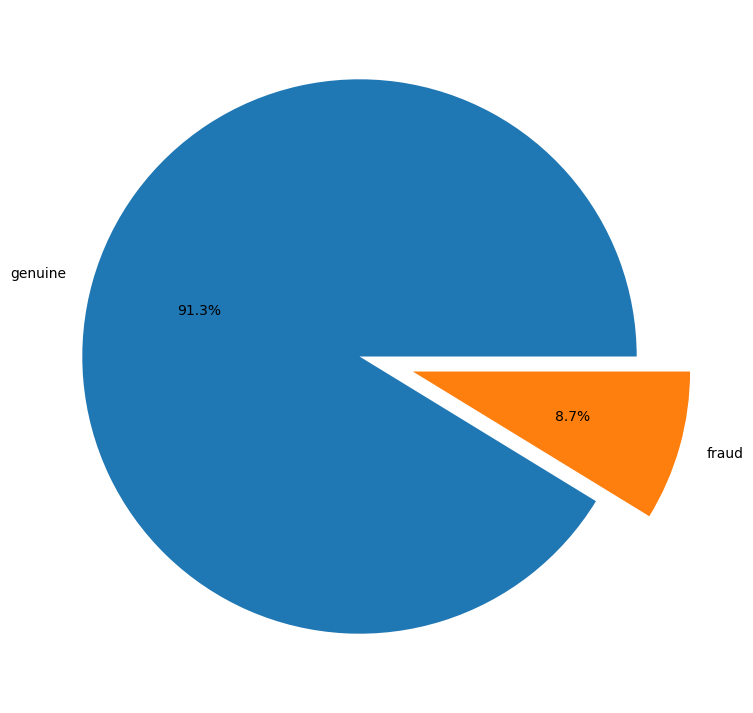

In [22]:
vc = df['fraud'].value_counts(ascending=False)

plt.pie(x=vc.values, labels=['genuine','fraud'], explode=[0.0, 0.2], autopct='%1.1f%%')
plt.show()

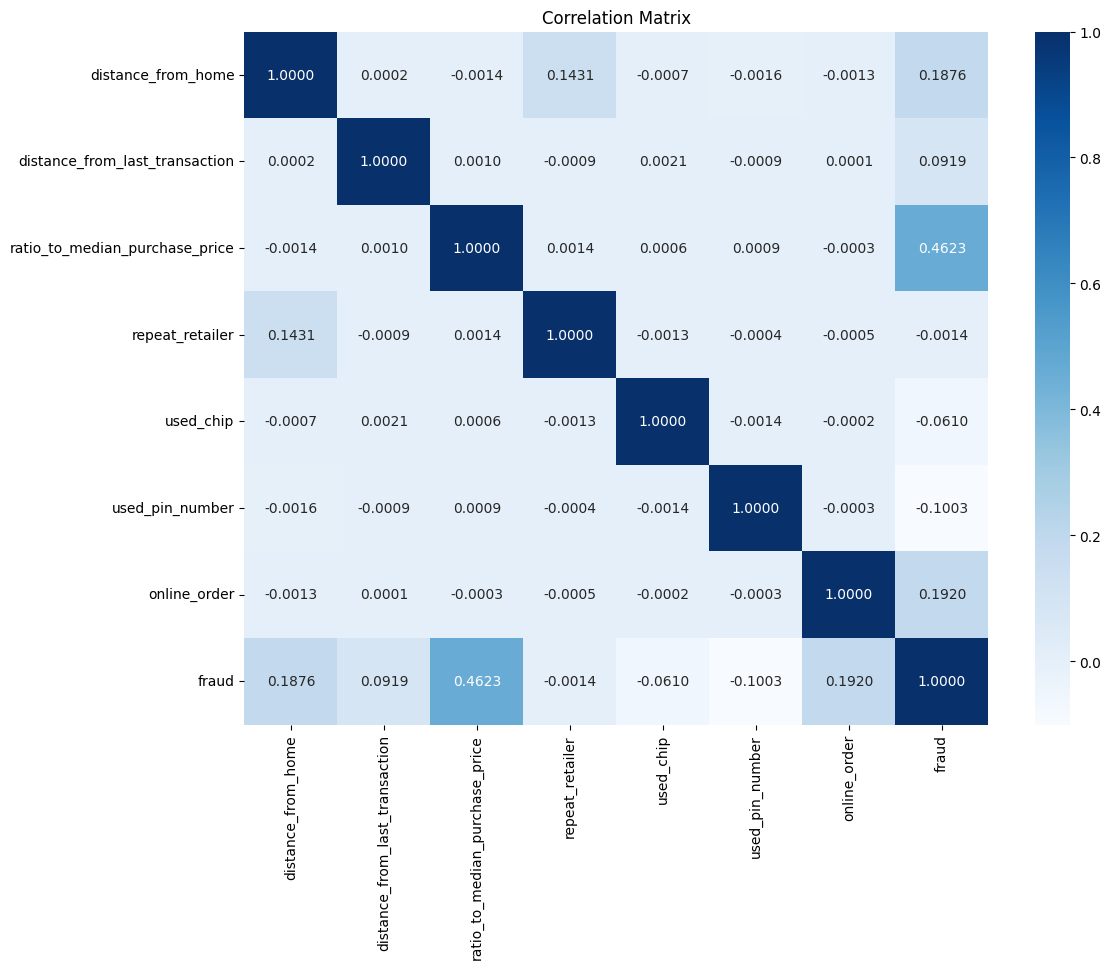

In [23]:
sns.heatmap(df.corr(), annot=True, fmt='.4f', cmap='Blues')
plt.title('Correlation Matrix')
plt.show()

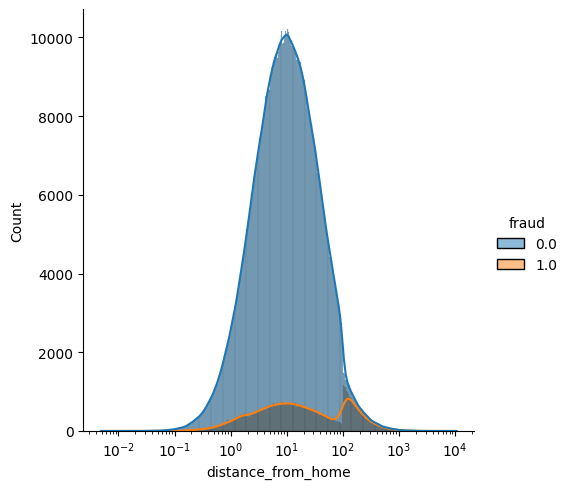

In [24]:
sns.displot(data=df, x='distance_from_home', hue='fraud', log_scale=True, kde=True)
plt.show()

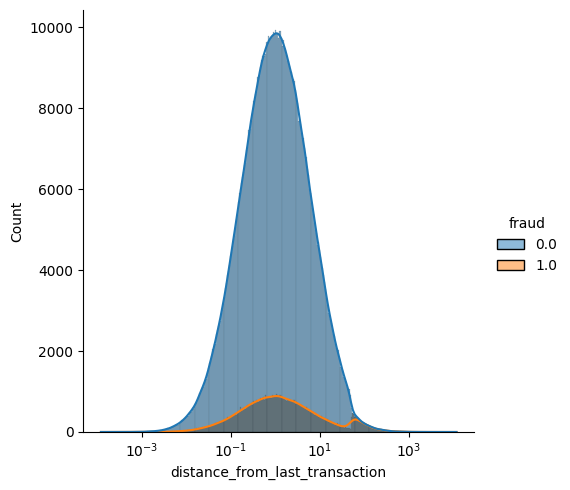

In [25]:
sns.displot(data=df, x='distance_from_last_transaction', hue='fraud', log_scale=True, kde=True)
plt.show()

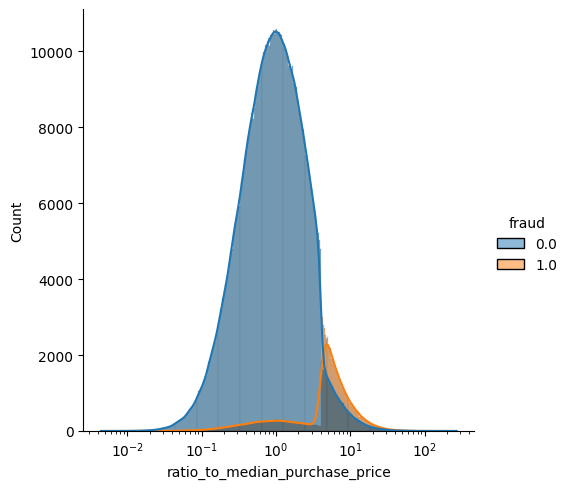

In [26]:
# 'ratio_to_median_purchase_price'
sns.displot(data=df, x='ratio_to_median_purchase_price', hue='fraud', log_scale=True, kde=True)
plt.show()

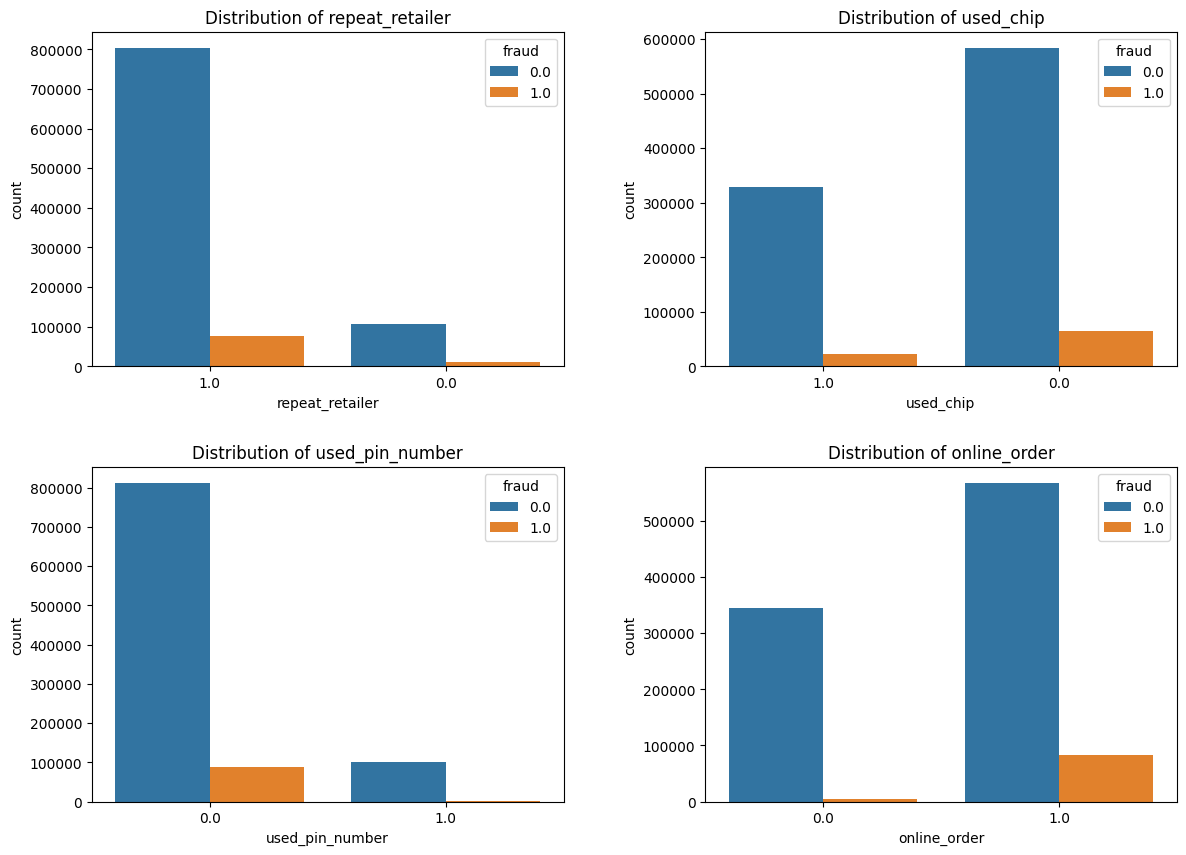

In [27]:
feats_to_plot = df.columns[3:-1]
plt.figure(figsize=(14,10))
for i, col in enumerate(feats_to_plot):
    plt.subplot(2,2,i+1)
    sns.countplot(x=df[col].astype(str), hue=df['fraud'])
    plt.title(f'Distribution of {col}')
plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.show()

In [28]:
ct = make_column_transformer(
    (StandardScaler(), num_feats)
)

df_scaled = pd.DataFrame(ct.fit_transform(df), columns=num_feats)
df_cat_feats = df[cat_feats]

df_concat = pd.concat([df_scaled, df_cat_feats], axis=1)
df_concat.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,0.477882,-0.182849,0.043491,1.0,1.0,0.0,0.0,0.0
1,-0.241607,-0.188094,-0.189300,1.0,0.0,0.0,0.0,0.0
2,-0.329369,-0.163733,-0.498812,1.0,0.0,0.0,1.0,0.0
3,-0.372854,0.021806,-0.522048,1.0,1.0,0.0,1.0,0.0
4,0.268572,-0.172968,0.142373,1.0,1.0,0.0,1.0,0.0


In [29]:
X = df_concat.drop(['fraud'], axis=1)
y = df_concat['fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=40)

y_train = y_train.astype(bool)
y_test = y_test.astype(bool)

# note x train genuine means no fraud transaction 
X_train_genuine = X_train[~y_train]
X_test_genuine = X_test[~y_test]

# x train fraud means fraud detection 
X_train_fraud = X_train[y_train]
X_test_fraud = X_test[y_test]

In [57]:
X_test.shape

(200000, 7)

In [30]:
CODE_DIM = 2
INPUT_SHAPE = X_train.shape[1]

input_layer = Input(shape=(INPUT_SHAPE,))
x = Dense(64, activation='relu')(input_layer)
x = Dense(16, activation='relu')(x)
code = Dense(CODE_DIM, activation='relu')(x)
x = Dense(16, activation='relu')(code)
x = Dense(64, activation='relu')(x)
output_layer = Dense(INPUT_SHAPE, activation='relu')(x)

autoencoder = Model(input_layer, output_layer, name='anomaly')

In [31]:
model_name = "anomaly.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            save_weights_only=True,
                            verbose=1)
earlystopping = EarlyStopping(monitor='val_loss',
                              min_delta = 0, 
                              patience = 5, 
                              verbose = 1,
                              restore_best_weights=True)

callbacks = [checkpoint, earlystopping]

ValueError: When using `save_weights_only=True` in `ModelCheckpoint`, the filepath provided must end in `.weights.h5` (Keras weights format). Received: filepath=anomaly.h5

In [32]:
autoencoder.compile(loss='mae',
                    optimizer=Adam())

In [33]:
history = autoencoder.fit(X_train_genuine, X_train_genuine,
                          epochs=25, batch_size=64,
                          validation_data=(X_test, X_test),
                        #   callbacks=callbacks,
                            shuffle=True)

Epoch 1/25
11408/11408 ━━━━━━━━━━━━━━━━━━━━ 27s 2ms/step - loss: 0.2446 - val_loss: 0.2513
Epoch 2/25
11408/11408 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - loss: 0.2369 - val_loss: 0.2511
Epoch 3/25
11408/11408 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 0.2342 - val_loss: 0.2438
Epoch 4/25
11408/11408 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 0.2319 - val_loss: 0.2426
Epoch 5/25
11408/11408 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - loss: 0.2317 - val_loss: 0.2428
Epoch 6/25
11408/11408 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 0.2321 - val_loss: 0.2428
Epoch 7/25
11408/11408 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - loss: 0.2317 - val_loss: 0.2427
Epoch 8/25
11408/11408 ━━━━━━━━━━━━━━━━━━━━ 25s 2ms/step - loss: 0.2317 - val_loss: 0.2429
Epoch 9/25
11408/11408 ━━━━━━━━━━━━━━━━━━━━ 27s 2ms/step - loss: 0.2316 - val_loss: 0.2425
Epoch 10/25
11408/11408 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - loss: 0.2314 - val_loss: 0.2424
Epoch 11/25
11408/11408 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - loss: 0.2314 - val_loss: 0.24

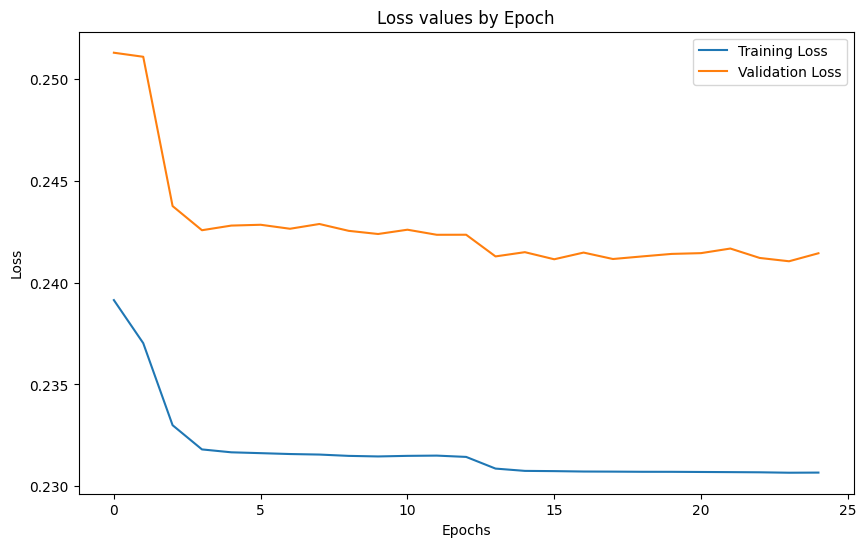

In [35]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title("Loss values by Epoch")
plt.show()

In [36]:
# mae = MeanAbsoluteError()

In [64]:
reconstructions = autoencoder.predict(X_test, verbose=0)
reconstruction_error = mae(reconstructions, X_test)
reconstruction_error

<tf.Tensor: shape=(200000,), dtype=float64, numpy=
array([0.25832034, 0.0270163 , 0.19287734, ..., 0.27668279, 0.28493135,
       0.28795957])>

In [63]:
from tensorflow.keras.losses import mae

In [65]:
reconstruction_error.shape

TensorShape([200000])

In [66]:
recons_df = pd.DataFrame({
    'error': reconstruction_error,
    'y_true': y_test
}).reset_index(drop=True)
recons_df.head()

,error,y_true
0,0.258320,False
1,0.027016,False
2,0.192877,True
3,0.248561,False
4,0.291457,False


In [ ]:
# finding he ideal thersold 

In [67]:
def thresholdTuning(df, iterations):
    
    thresh_df = {
        'threshold': [],
        'accuracy': [],
        'precision': [],
        'recall': []
    }
    
    for i in range(iterations):
        thresh_value = df['error'].quantile(i/iterations)
        preds = df['error'] > thresh_value
        cr = classification_report(df['y_true'], preds, output_dict=True)
        acc = cr['accuracy']
        prec = cr['macro avg']['precision']
        rc = cr['macro avg']['recall']
        
        thresh_df['threshold'].append(thresh_value)
        thresh_df['accuracy'].append(acc)
        thresh_df['precision'].append(prec)
        thresh_df['recall'].append(rc)
        
        print(f"Threshold: {thresh_value:.4f}\tAccuracy: {acc:.3f}\t\tPrecision: {prec:.3f}\tRecall Score: {rc:.3f}")
        
    return pd.DataFrame(thresh_df)
        
thresh_df = thresholdTuning(recons_df, 10)

Threshold: 0.0018	Accuracy: 0.087		Precision: 0.544	Recall Score: 0.500
Threshold: 0.0823	Accuracy: 0.184		Precision: 0.540	Recall Score: 0.546
Threshold: 0.1275	Accuracy: 0.283		Precision: 0.548	Recall Score: 0.596
Threshold: 0.1790	Accuracy: 0.371		Precision: 0.543	Recall Score: 0.614
Threshold: 0.2098	Accuracy: 0.427		Precision: 0.509	Recall Score: 0.528
Threshold: 0.2273	Accuracy: 0.486		Precision: 0.486	Recall Score: 0.455
Threshold: 0.2517	Accuracy: 0.579		Precision: 0.496	Recall Score: 0.488
Threshold: 0.2719	Accuracy: 0.676		Precision: 0.512	Recall Score: 0.533
Threshold: 0.2944	Accuracy: 0.773		Precision: 0.540	Recall Score: 0.580
Threshold: 0.3725	Accuracy: 0.865		Precision: 0.596	Recall Score: 0.609


In [68]:
thresh_df

,threshold,accuracy,precision,recall
0,0.001773,0.087315,0.543655,0.500003
1,0.082290,0.184380,0.540367,0.545591
2,0.127544,0.282890,0.547662,0.595699
3,0.178956,0.371270,0.543269,0.614027
4,0.209847,0.426540,0.509456,0.528480
5,0.227290,0.485810,0.485810,0.455482
6,0.251653,0.578740,0.496044,0.488085
7,0.271940,0.675560,0.512481,0.532891
8,0.294443,0.773010,0.539681,0.579674
9,0.372504,0.864760,0.596133,0.608575


In [69]:
threshold = thresh_df[thresh_df['recall'] == thresh_df['recall'].max()]['threshold'].values[0]
print(f"Threshold with Maximum Recall: {threshold:.6f}")

Threshold with Maximum Recall: 0.178956


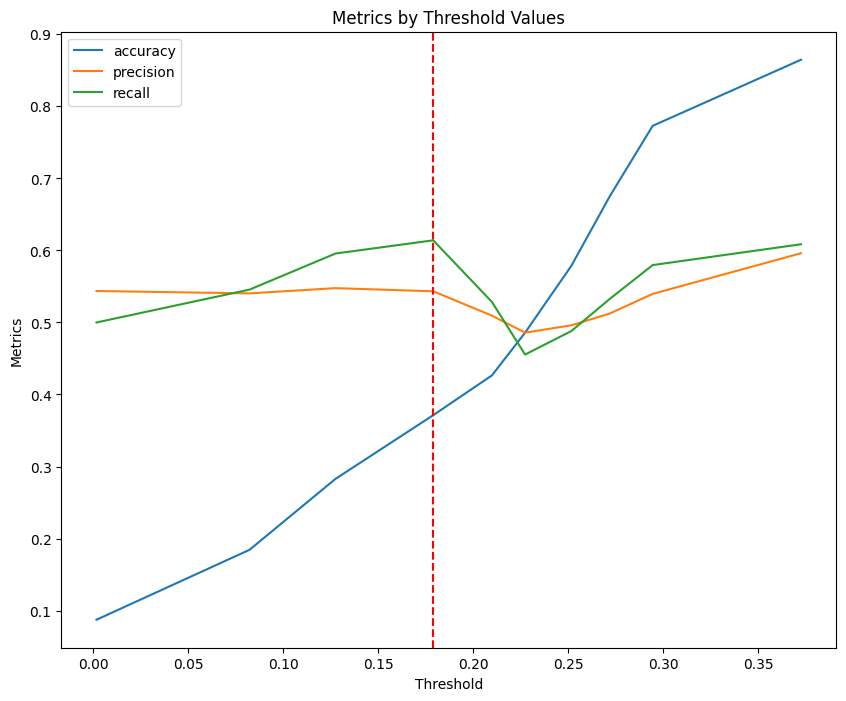

In [70]:
plt.figure(figsize=(10,8))
plt.plot(thresh_df['threshold'], thresh_df['accuracy'], label='accuracy')
plt.plot(thresh_df['threshold'], thresh_df['precision'], label='precision')
plt.plot(thresh_df['threshold'], thresh_df['recall'], label='recall')
plt.axvline(x=threshold, color='r', linestyle='dashed')
plt.xlabel('Threshold')
plt.ylabel('Metrics')
plt.title('Metrics by Threshold Values')
plt.legend()
plt.show()

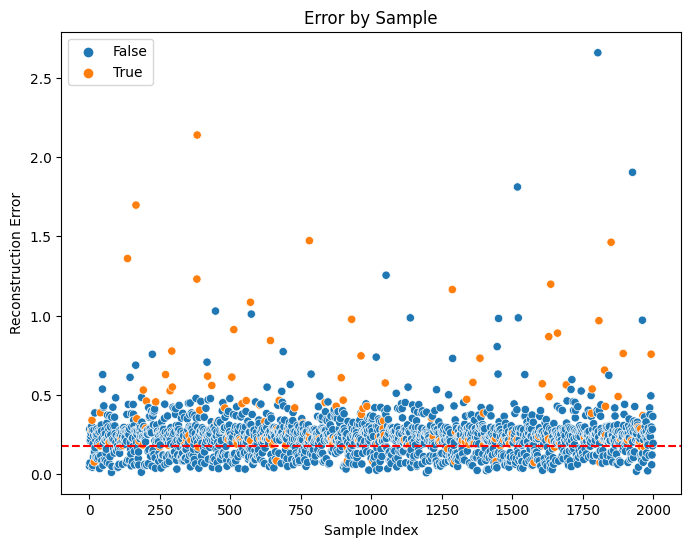

In [71]:
temp = recons_df.sample(frac=0.01, random_state=42).reset_index(drop=True)
plt.figure(figsize=(8,6))
sns.scatterplot(data=temp, x=temp.index, y='error', hue='y_true')
plt.axhline(y=threshold, color='r', linestyle='dashed')
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Error')
plt.title('Error by Sample')
plt.legend()
plt.show()

In [72]:
recons_df['y_pred'] = recons_df['error'] > threshold
recons_df.head()

,error,y_true,y_pred
0,0.258320,False,True
1,0.027016,False,False
2,0.192877,True,True
3,0.248561,False,True
4,0.291457,False,True


In [73]:
print(classification_report(recons_df['y_true'],recons_df['y_pred']))

              precision    recall  f1-score   support

       False       0.97      0.32      0.48    182538
        True       0.11      0.91      0.20     17462

    accuracy                           0.37    200000
   macro avg       0.54      0.61      0.34    200000
weighted avg       0.90      0.37      0.46    200000



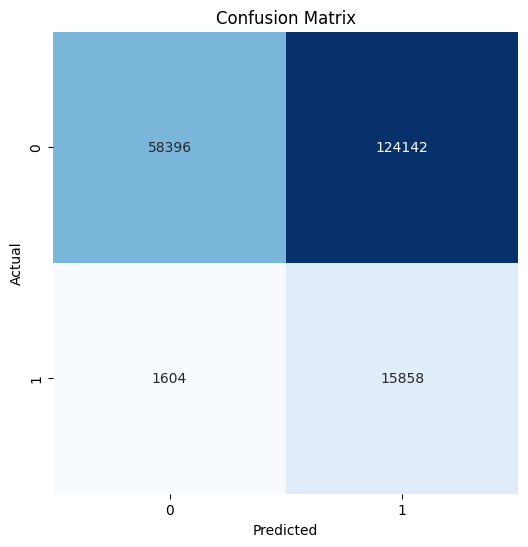

In [74]:
cm = confusion_matrix(recons_df['y_true'],recons_df['y_pred'])
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, cmap='Blues', cbar=False, fmt='.6g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [75]:
print(f"Recall Score: {recall_score(recons_df['y_true'],recons_df['y_pred'])*100:.3f}%")
print(f"Accuracy Score: {accuracy_score(recons_df['y_true'],recons_df['y_pred'])*100:.3f}%")

Recall Score: 90.814%
Accuracy Score: 37.127%


In [ ]:
# conclusion

